In this notebook we prepare the data (data cleaning and feature engineering) for modelling.

# Load modules and data

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
from itertools import product
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_rows = None

Read all the data files

In [2]:
items = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
train = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')
sample_submission = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
item_categories = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

Set the right time format.

In [3]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

# Outliers

<AxesSubplot:xlabel='item_price'>

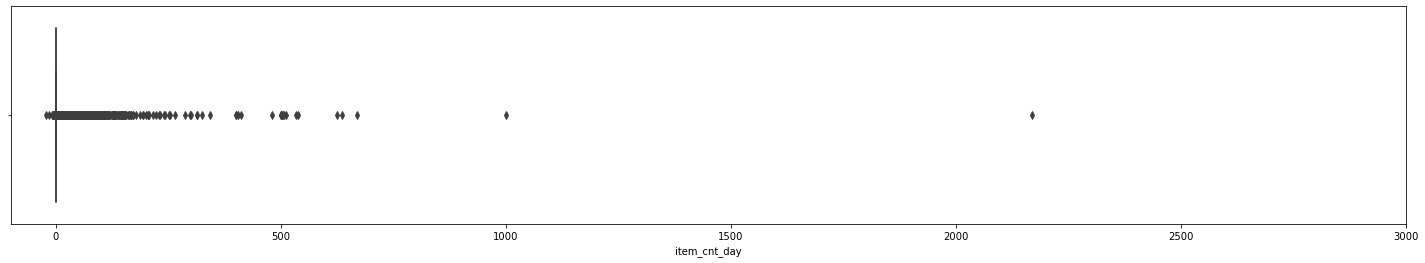

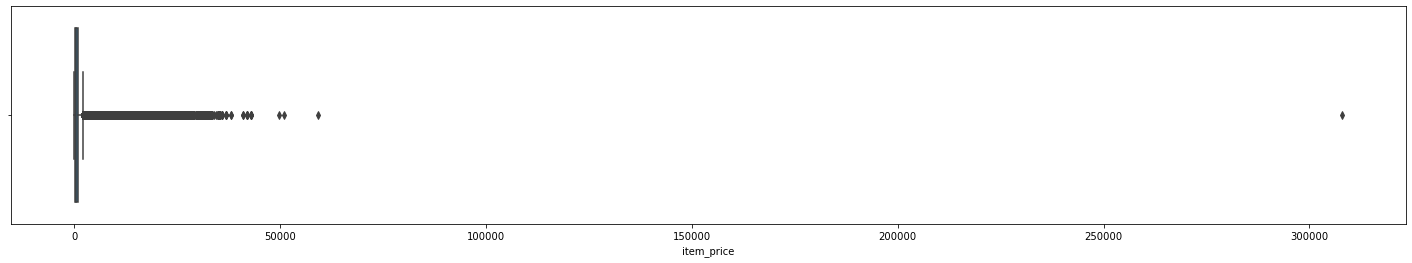

In [4]:
plt.figure(figsize = (25, 4))
plt.xlim(-100, 3000)
sns.boxplot(x = train.item_cnt_day)

plt.figure(figsize = (25, 4))
sns.boxplot(x = train.item_price)

We remove item counts and prices that are clearly outliers.

In [5]:
#train = train[train.item_cnt_day < 1001]
train = train[train.item_cnt_day < 1000]
train = train[train.item_price < 100000]

We also remove an item where item_price < 0.

In [6]:
train = train[train.item_price > 0]

There are duplicates of the shops' names, which we adjust for.

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Preprocessing of shops, categories and items

## Shops

Clean up some shop_names.

Each shop_name starts with the name of the city the shop is located in. This information might be important.

The second part of the shop_name is the category the shop belongs to.

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops["category"] = shops.shop_name.str.split(' ').map(lambda x: x[1])

<AxesSubplot:xlabel='category', ylabel='count'>

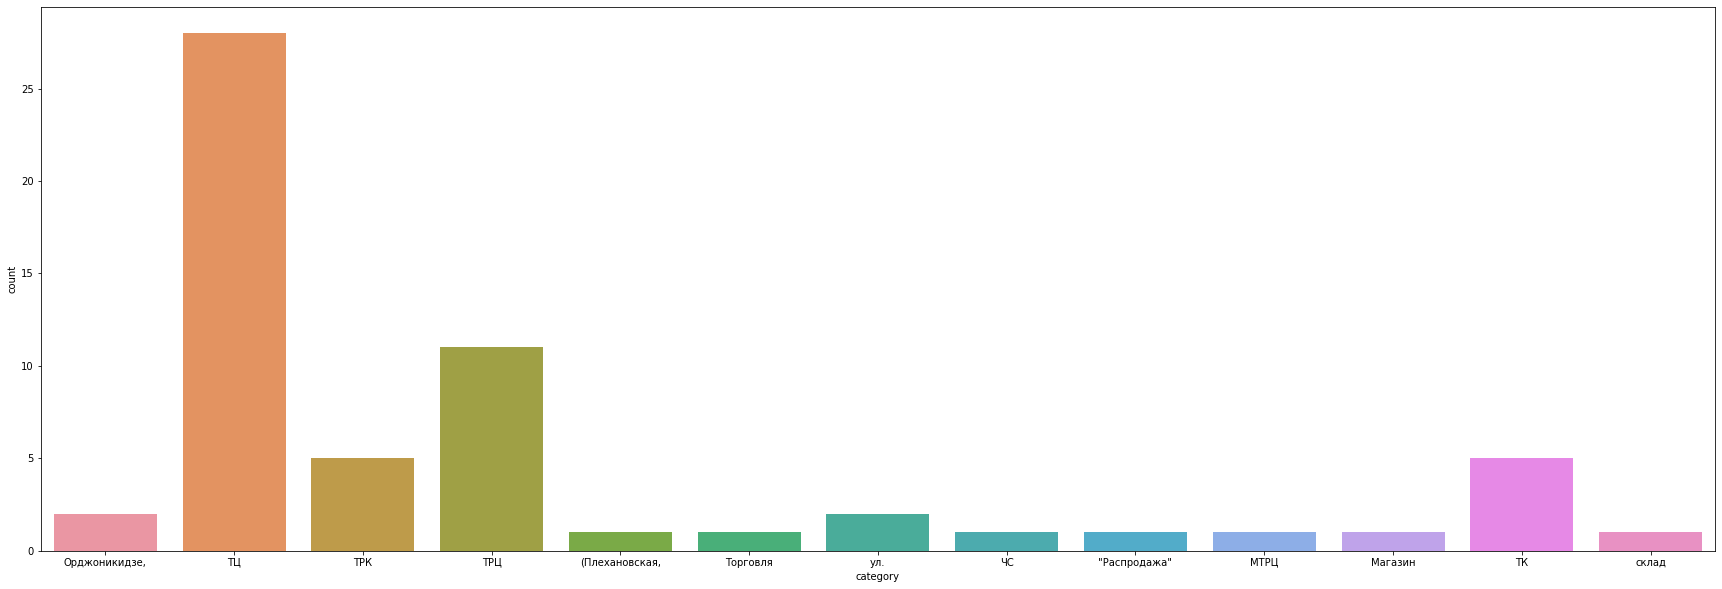

In [9]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'category', data = shops)

We only keep a category if there are 5 or more shops of that category, otherwise we set 'Other'.

In [10]:
categories = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        categories.append(cat)
shops.category = shops.category.apply(lambda x: x if (x in categories) else 'Other')

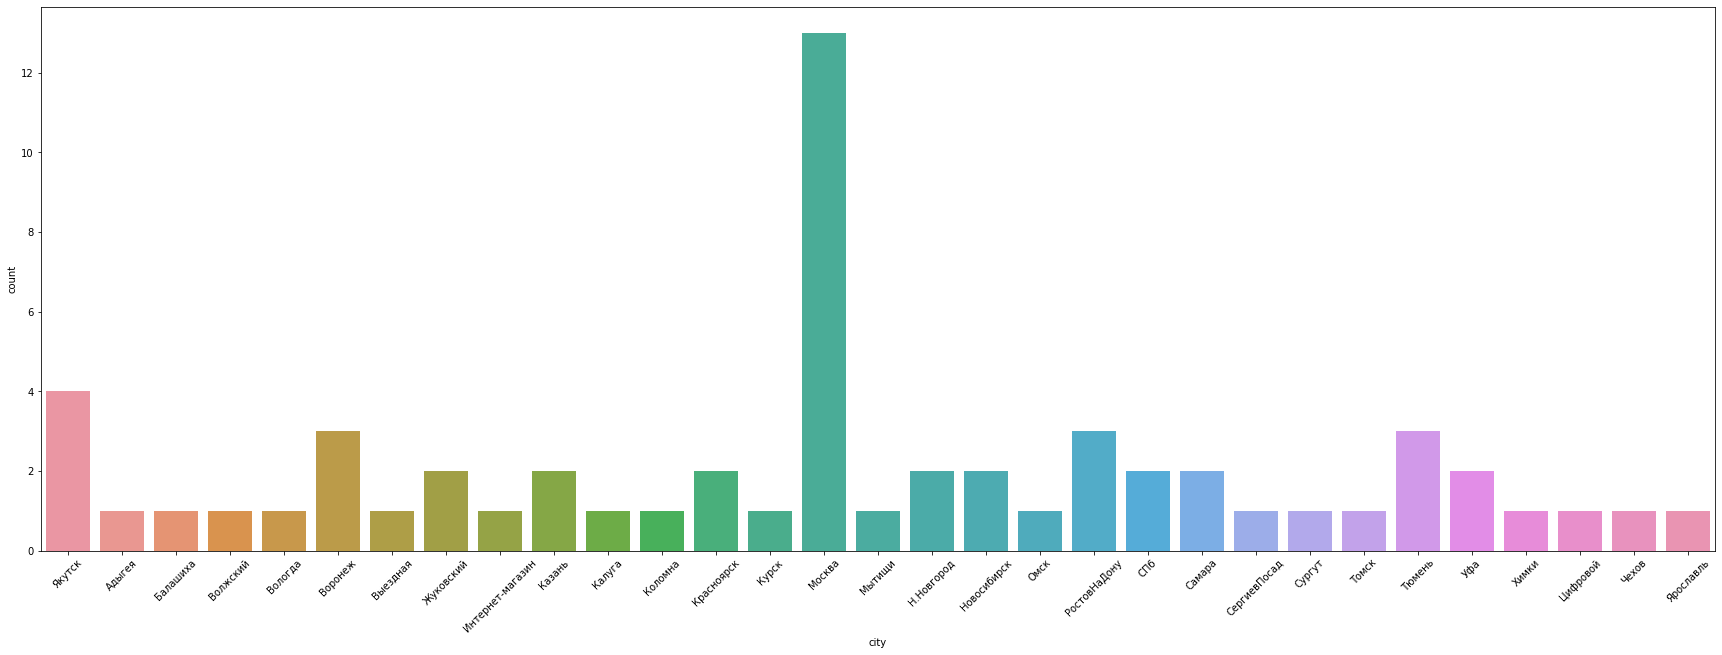

In [11]:
plt.figure(figsize = (30, 10))
g = sns.countplot(x = 'city', data = shops)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
None

One city (Moscow) is found much more frequently than the others.

We only keep a city if there are 2 or more of them. 

**Note:** In the early xgb models we've trained, city_code was not used as a feature at all, so it's worth trying.

In [12]:
cities = []
for city in shops.city.unique():
    if len(shops[shops.city == city]) >= 2:
        cities.append(city)
shops.city = shops.city.apply(lambda x: x if (x in cities) else 'Other')

shops["category_code"] = LabelEncoder().fit_transform(shops.category)
shops["city_code"] = LabelEncoder().fit_transform(shops.city )
shops = shops[["shop_id", "category_code", "city_code"]]

## Categories

In [13]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Each category contains a type and subtype (with some exceptions). We also perform some cleaning

In [176]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip()) # All leading and trailing
# whitespaces are removed from the string
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# If subtype is not available we set type as subtype.

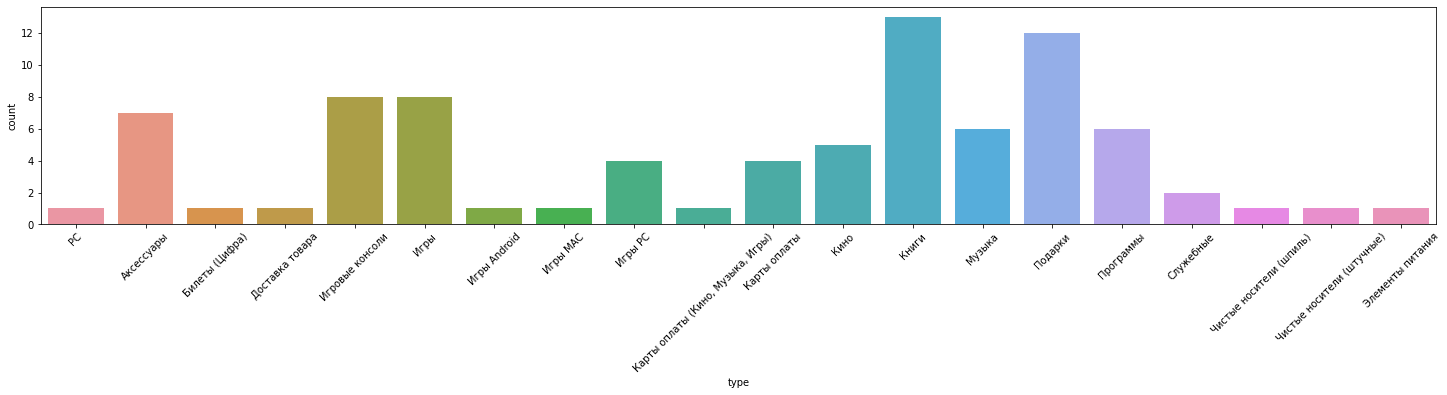

In [177]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'type', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
None

We only keep a type if there are 5 or more of them. From the feature importances of the models we've already trained we know that this is not a very important feature, so binning might improve it.

In [178]:
types = []
for my_type in item_categories.type.unique():
    if len(item_categories[item_categories.type == my_type]) >= 5: 
        types.append(my_type)
item_categories.type = item_categories.type.apply(lambda x: x if (x in types) else "Other")

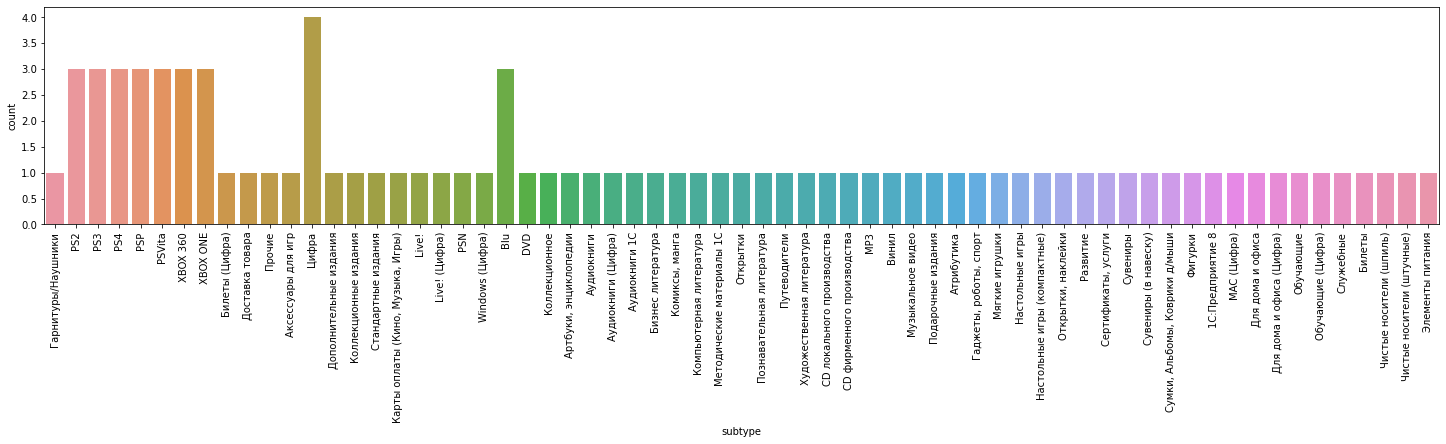

In [179]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'subtype', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

From the models we have already trained we can see that subtype is already quite important as a feature, so we leave it as it is.

In [180]:
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

## Items

We will do some corrections of item_name.

In [181]:
def name_correction(x):
    x = x.lower() # Make all letters lower case.
    x = x.partition('[')[0] # Partition by square brackets.
    x = x.partition('(')[0] # Partition by curly brackets.
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # Remove special characters.
    x = x.replace('  ', ' ') # Replace double spaces with single spaces.
    x = x.strip() # Remove leading and trailing white space.
    return x

Split item name into two parts (depending on which type of bracket is found).

In [182]:
items[["item_name1", "item_name2"]] = items.item_name.str.split("[", 1, expand = True)
items[["item_name1", "item_name3"]] = items.item_name.str.split("(", 1, expand = True)

items["item_name2"] = items.item_name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["item_name3"] = items.item_name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

<ipython-input-182-3e3e65d149b9>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  items["item_name2"] = items.item_name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
<ipython-input-182-3e3e65d149b9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  items["item_name3"] = items.item_name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()


Set type column and clean it.

In [183]:
items["type"] = items.item_name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") , "type"] = "xbox 360"
items.loc[items.type == "", "type"] = "mac"
items.type = items.type.apply(lambda x: x.replace(" ", ""))
items.loc[(items.type == 'pc' ) | (items.type == 'pс') | (items.type == "pc"), "type"] = "pc"
items.loc[items.type == 'рs3', "type"] = "ps3"

'0' and 'pc' occur much more frequently than the other categories, so we don't plot them.

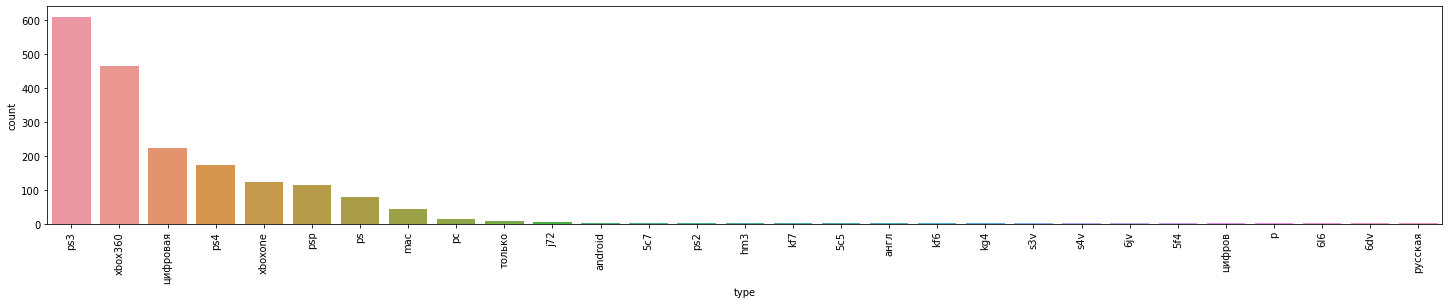

In [184]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = "type", data = items[~items.type.isin(["0", "pc"])], \
                  order = items[~items.type.isin(["0", "pc"])]['type'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

We only consider types that occur more than 40 times.

In [185]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cats = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <= 40:
        drop_cats.append(cat)
items.item_name2 = items.item_name2.apply(lambda x: "Other" if (x in drop_cats) else x )
items = items.drop(["type"], axis = 1)

items.item_name2 = LabelEncoder().fit_transform(items.item_name2)
items.item_name3 = LabelEncoder().fit_transform(items.item_name3)

items = items.drop(["item_name", "item_name1"], axis = 1)

# Monthly aggregation of data and feature engineering

Add revenue as a feature.

In [186]:
train['revenue'] = train['item_cnt_day'] * train['item_price']

Consider all possible pairs of item/shop in each date_block_num.

In [187]:
index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid for all shop/item combinations from that month.
grid = [] 
ts = time.time()
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(product([block_num], cur_shops, cur_items)), dtype = 'int16'))

# Turn the grid into a pandas dataframe.
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

grid.sort_values(index_cols, inplace = True)
time.time() - ts

15.25802731513977

Adjust the test set - add date_block_num = 34 (November 2015).

In [188]:
test["date_block_num"] = 34

Concatenate train and test sets to make it easier to add features.

In [189]:
grid = pd.concat([grid, test.drop("ID", axis = 1)], ignore_index = True, sort = False, keys = index_cols)

## Add shops, items and item_categories features.

Add features related to the id of shops, items and categories.

In [419]:
ts = time.time()
grid = pd.merge(grid, shops, on = ['shop_id'], how = 'left')
grid = pd.merge(grid, items, on = ['item_id'], how = 'left')
grid = pd.merge(grid, item_categories, on = ['item_category_id'], how = 'left')
time.time() - ts

2.5347492694854736

## Target variable and target lags

Obtain the target.

In [420]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['sum']})
train_monthly.columns = ['item_cnt_month_shop_item']
train_monthly = train_monthly.reset_index()
grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )
time.time() - ts

3.9603912830352783

Fill NaNs with 0 in the target and clip to the range [0, 20] (the range that will be considered on evaluation).

In [421]:
grid['item_cnt_month_shop_item'] = grid['item_cnt_month_shop_item'].fillna(0).clip(0,20)

Define the function we use to get lagged values of relevant aggregated quantities and the lags we will use (in general).

In [422]:
def lag_feature(df, lags, cols):
    for col in cols:
        print('Adding lagged feature(s) for:', col)
        tmp = df[index_cols + [col]]
        for i in lags:
            shifted = tmp.copy()            
            shifted.columns = index_cols + [col + "_lag_" + str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on = index_cols, how = 'left')
    return df

lags = [1, 2, 3]

Add lags of the target.

In [423]:
ts = time.time()
grid = lag_feature(grid, lags, ['item_cnt_month_shop_item'])
time.time() - ts

Adding lagged feature(s) for: item_cnt_month_shop_item


16.493990421295166

Downcast to save memory.

In [424]:
def downcast(df):
    for col in grid.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype(np.int16)
        if df[col].dtype == 'float64':
            df[col] = df[col].astype(np.float16)
    return(df)

grid = downcast(grid)

## Mean encoded features

Add aggregated values for date_block_num, shop_id and item_id (index_cols).

In [425]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum'], })
train_monthly.columns = ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'])

grid = grid.drop(['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_price_month_shop_item_mean
Adding lagged feature(s) for: revenue_month_shop_item


53.79651069641113

**Note:** We must drop item_cnt_month_shop_item_mean, item_price_month_shop_item_mean and revenue_month_shop_item, otherwise we have data leakage (information extracted from the target is contained in a feature). item_cnt_month_shop_item is our target, so we keep it for now.

In [426]:
grid = downcast(grid)

Add aggregated values for date_block_num and shop_id.

In [427]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_shop_mean',  'item_price_month_shop_mean', 'revenue_month_shop']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'shop_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'])

grid = grid.drop(['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding lagged feature(s) for: revenue_month_shop


50.54824423789978

In [428]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_id.

In [429]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'item_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'])

grid = grid.drop(['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding lagged feature(s) for: revenue_month_item


51.496835470199585

In [430]:
grid = downcast(grid)

Add aggregated values only for date_block_num.

In [431]:
ts = time.time()
train_monthly = train.groupby('date_block_num').agg({'item_cnt_day':['mean']})
train_monthly.columns = ['item_cnt_month_mean']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_mean'])

grid = grid.drop('item_cnt_month_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_mean


18.93087077140808

In [432]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_category_id.

In [433]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_cat_mean'])

grid = grid.drop('item_cnt_month_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_cat_mean


19.481481075286865

In [434]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and item_category_id.

In [435]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_cat_mean'])

grid = grid.drop('item_cnt_month_shop_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean


20.180750846862793

In [436]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and type_code.

In [437]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_type_code_mean'])

grid = grid.drop('item_cnt_month_shop_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean


20.18601107597351

In [438]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and subtype_code.

In [439]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_subtype_code_mean'])

grid = grid.drop('item_cnt_month_shop_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean


20.884056329727173

In [440]:
grid = downcast(grid)

Add aggregated values for date_block_num and city_code.

In [441]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_city_code_mean'])

grid = grid.drop('item_cnt_month_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_city_code_mean


20.892166137695312

In [442]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and city_code.

In [443]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_city_code_mean'])

grid = grid.drop('item_cnt_month_shop_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean


22.23766303062439

In [444]:
grid = downcast(grid)

Add aggregated values for date_block_num, item_id and city_code.

In [445]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_city_code_mean'])

grid = grid.drop('item_cnt_month_item_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_city_code_mean


24.46163249015808

In [446]:
grid = downcast(grid)

Add aggregated values for date_block_num and type_code.

In [447]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_type_code_mean'])

grid = grid.drop('item_cnt_month_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_type_code_mean


22.252869129180908

In [448]:
grid = downcast(grid)

Add aggregated values for date_block_num and subtype_code.

In [449]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_subtype_code_mean'])

grid = grid.drop('item_cnt_month_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_subtype_code_mean


22.29711413383484

In [450]:
grid = downcast(grid)

## Trend related features

Add global average item_price (for train data), use lag values of item_price per month and add delta price values (how the current month's average price relates to the global average).

In [451]:
ts = time.time()
#train_agg = train.groupby(['item_id']).agg({'item_price': ['mean']})
train_agg = train[train['date_block_num'] < 33].groupby(['item_id']).agg({'item_price': ['mean']}) # In order to 
# avoid data leakage we exclude the validation period.
train_agg.columns = ['item_price_item_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['item_id'], how = "left")

for i in lags:
    grid['delta_price_lag_' + str(i) ] = (grid['item_price_month_item_mean_lag_' + str(i)] - \
                                          grid['item_price_item_mean']) / grid['item_price_item_mean']
    
def select_trends(row): # Choose the first NaN value.
    for i in lags:
        if ~np.isnan(row["delta_price_lag_" + str(i)]):
            return row["delta_price_lag_" + str(i)]
    return 0

grid = downcast(grid)

grid['delta_price_lag'] = grid.apply(select_trends, axis = 1)
#grid['delta_price_lag'] = grid['delta_price_lag'].fillna(0) # This cannot be a valid solution I think.
grid['delta_price_lag'] = grid['delta_price_lag'].fillna(-999) # Let's try this and see if it works.

#fetures_to_drop = ['item_price_item_mean', 'item_price_month_item_mean'] # item_price_month_item_mean is already 
# dropped
features_to_drop = ['item_price_item_mean']
for i in lags:
    #fetures_to_drop += ['item_price_month_mean_lag_' + str(i)] # We should be able to keep these fetures
    features_to_drop += ['delta_price_lag_' + str(i)]

grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

178.61857438087463

**Note:** For the test data, item_price_item_mean should be calculated for the entire time period (train + val) if we are to be completely consistent.

In [452]:
grid = downcast(grid)

Add delta revenue values (how the last month's revenue relates to the global average)

In [453]:
ts = time.time()
train_agg = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
train_agg.columns = ['revenue_month_shop']
train_agg = train_agg.reset_index()

grid = pd.merge(grid, train_agg, on=['date_block_num','shop_id'], how='left')

#train_agg = train.groupby(['shop_id']).agg({'revenue': ['mean']})
train_agg = train[train['date_block_num'] < 33].groupby(['shop_id']).agg({'revenue': ['mean']}) # In order to 
# avoid data leakage we exclude the validation period.
train_agg.columns = ['revenue_shop_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['shop_id'], how = "left")

grid['delta_revenue'] = (grid['revenue_month_shop'] - grid['revenue_shop_mean']) / grid['revenue_month_shop']

grid = downcast(grid)

grid = lag_feature(grid, [1], ['delta_revenue']) # Only consider one lag here.

features_to_drop = ['revenue_month_shop', 'revenue_shop_mean', 'delta_revenue']
grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

Adding lagged feature(s) for: delta_revenue


13.472140312194824

In [454]:
grid = downcast(grid)

## Special features

Add the number of the month as a feature.

In [455]:
grid['month'] = grid['date_block_num'] % 12

Add the number of days in the month (no leap years).

In [456]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid['no_days_in_month'] = grid['month'].map(days)

In [457]:
grid = downcast(grid)

Add the number of months since the last sale for each shop/item pair.

In [458]:
ts = time.time()
cache = {}
#grid['item_shop_last_sale'] = -1 # The default value if no previous sale is found. Could it be set to -999?
grid['item_shop_last_sale'] = -999 # We try using -999 to fill NAs.
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')
    shop_id = getattr(row,'shop_id')
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)+' '+str(shop_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_shop_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

197.25031900405884

Add number of months since the last sale for each item.

In [459]:
ts = time.time()
cache = {}
#grid['item_last_sale'] = -1
grid['item_last_sale'] = -999 # We try using -999 to fill NAs.
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')    
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

308.86150670051575

Add number of months since the first sale for each shop/item pair, and only item respectively.

In [460]:
ts = time.time()
grid['item_shop_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id','shop_id'])['date_block_num']\
.transform('min')
grid['item_first_sale'] = grid['date_block_num'] - grid.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.325516939163208

In [461]:
grid = downcast(grid)

## Final preparation

Replace any eventual infinite values with 0.

In [462]:
grid = grid.replace(np.inf, 0)

Delete the first three months from grid as they definitely do not have any lag values.

In [193]:
grid = grid[grid["date_block_num"] > (len(lags) - 1)]

In [464]:
grid.isnull().sum(axis = 0)

date_block_num                                       0
shop_id                                              0
item_id                                              0
category_code                                        0
city_code                                            0
item_category_id                                     0
item_name2                                           0
item_name3                                           0
type_code                                            0
subtype_code                                         0
item_cnt_month_shop_item                             0
item_cnt_month_shop_item_lag_1                 2011893
item_cnt_month_shop_item_lag_2                 2321638
item_cnt_month_shop_item_lag_3                 2626126
item_cnt_month_shop_item_mean_lag_1            8596842
item_cnt_month_shop_item_mean_lag_2            8606777
item_cnt_month_shop_item_mean_lag_3            8618244
item_price_month_shop_item_mean_lag_1          8596842
item_price

Fill NaNs in lag features with 0.

In [465]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            #if ('item_cnt' in col): # This is probably valid.
            if ('item_cnt' in col) or ('revenue' in col): # If it's valid for item_cnt, it should be valid for 
                # revenue as well since revenue = item_cnt * price.
                df[col].fillna(0, inplace = True)
            if ('item_price_month_shop_item_mean_lag_' in col) or ('item_price_month_shop_mean_lag_' in col) or \
            ('item_price_month_item_mean_lag_' in col):
                df[col].fillna(-999, inplace = True) # It doesn't make sense to fill price related lag features \
                # with 0.
                
    return df

grid = fill_na(grid)
time.time() - ts

5.371837377548218

In [466]:
grid.isnull().sum(axis = 0)

date_block_num                                 0
shop_id                                        0
item_id                                        0
category_code                                  0
city_code                                      0
item_category_id                               0
item_name2                                     0
item_name3                                     0
type_code                                      0
subtype_code                                   0
item_cnt_month_shop_item                       0
item_cnt_month_shop_item_lag_1                 0
item_cnt_month_shop_item_lag_2                 0
item_cnt_month_shop_item_lag_3                 0
item_cnt_month_shop_item_mean_lag_1            0
item_cnt_month_shop_item_mean_lag_2            0
item_cnt_month_shop_item_mean_lag_3            0
item_price_month_shop_item_mean_lag_1          0
item_price_month_shop_item_mean_lag_2          0
item_price_month_shop_item_mean_lag_3          0
revenue_month_shop_i

In [467]:
data = grid.copy()
del grid
gc.collect()

143

Save the data in a pickle file.

In [468]:
data.to_pickle('data.pkl')